In [2]:
import numpy as np
import pandas    as pd
import geopandas as geopd
import seaborn   as sea 
from   scipy     import stats
import matplotlib.pyplot as plt
from pyspark.sql       import SparkSession
from pyspark.sql       import functions as f
from pyspark.sql.types import *

### Data & AI - PB Fast Learning - Ciência de Dados - 1/3 Desafio

> Neste projeto ficarei usando pandas, pyspark([sql]()),  pyspark([dataframe]()) mais vou utilizar mais as duas ultimas pois já tenho um certo conhecimento em Pandas e quero aprender|fixar o conhecimento sobre o Pyspark. 

Criando Seção no spark

In [3]:
spark = SparkSession.builder\
    .appName('ProjetoSprint01-Desafio')\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/08 18:05:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Carregando dados usando pyspark
> Defini o tipo do Schema(com o `StructType`) para alguns Conj. dados pois estavam tipando errado o schema, por exemplo, **`geolocation_zip_code_prefix`** que seus atributos são do tipo string contedo só numero de caracteres, mas estavam sendo colocados como do tipo `integer`.

In [4]:
option1 = dict(inferschema='false',header='true' ,delimiter=',')
option2 = dict(inferschema='true' ,header='true' ,delimiter=',')
optionReview = dict(delimiter=',' ,inferschema='true' ,header='true', 
                    escape="\"", multiLine='true')
# olist_customers_dataset
customers     = spark.read.format('csv')\
    .options(**option1).load('dataset/olist_customers_dataset.csv')

geolocation   = spark.read.format('csv')\
    .options(**option1).load('dataset/olist_geolocation_dataset.csv')

# olist_order_payments_dataset
payments      = spark.read.format('csv')\
    .options(**option2).load('dataset/olist_order_payments_dataset.csv')

# olist_orders_dataset
orders        = spark.read.format('csv')\
    .options(**option2).load('dataset/olist_orders_dataset.csv')

# olist_order_items_dataset
order_items   = spark.read.format('csv')\
    .options(**option2).load('dataset/olist_order_items_dataset.csv')

# olist_order_reviews_dataset
order_reviews = spark.read.format('csv')\
    .options(**optionReview).load('dataset/olist_order_reviews_dataset.csv')

# olist_products_dataset
order_product = spark.read.format('csv')\
    .options(**option2).load('dataset/olist_products_dataset.csv')

# olist_sellers_dataset
sellers      = spark.read.format('csv')\
    .options(**option2).load('dataset/olist_sellers_dataset.csv')

# product_category_dataset
product_cat  = spark.read.format('csv')\
    .options(**option2).load('dataset/product_category_name_translation.csv')

```python
optionReview = dict(delimiter=',' ,inferschema='true' ,header='true', 
                    escape="\"", multiLine='true')
```
> Foi feito dessa for pois o antes o spark estava lendo errado o conj. dados `ORDER_REVIEW`. Nas outras também, foram feita usando um dict para reduzir o número de linhas e tornar mais de saber o que estou fazendo...

Criando uma visão temporaria , pois usarei o sql do spark para fazer as questões e melhor de entender oq estou fazendo

In [4]:
customers.createOrReplaceTempView('customers')
geolocation.createOrReplaceTempView('geolocation')
orders.createOrReplaceTempView('orders')
order_items.createOrReplaceTempView('order_items')
order_product.createOrReplaceTempView('order_product')
order_reviews.createOrReplaceTempView('order_reviews')
payments.createOrReplaceTempView('payments')
sellers.createOrReplaceTempView('sellers')
product_cat.createOrReplaceTempView('product_cat')

&nbsp;

# Analise

> Obs: Os pyspark será convertido para pandas para melhor visualização 

* Verificação de dados Nulos, fazerei uma função que recebe como parametros string(`nome do conj. dados`) e data(`conj. de dados em si`) ele irá me printar quantidade de valores nulos por coluna 
* Criei outra função que verifica a quantidade da valores duplicados do por coluna

In [5]:
def VerificaValoresNulos(string, data):
    count = data.count()
    selecao = data.select(
        [ f.count( f.when(f.isnull(col), col)).alias(col)  for col in data.columns ]
    ).toPandas().T
    selecao.columns = ['Quantidade de valores Nulos']
    selecao['%']    =  np.round((selecao['Quantidade de valores Nulos']/count)*100,4)
    print(f'Para o conjuto de dados {string.title()} , com {count} linhas')
    display(selecao)

def VerificaValoresDuplicados(data):
    count   = data.count()  
    selecao = data.select([
        ( count - f.countDistinct(f.col(column)) ).alias(column) for column in data.columns
    ]).toPandas().T
    selecao.columns = ['Quantidade de valores duplicados']
    selecao['%']    =  np.round((selecao['Quantidade de valores duplicados']/count)*100,4)
    
    display(selecao)

## Orders

In [6]:
print('Orders possue ',orders.count(), 'intancias')

Orders possue  99441 intancias


In [7]:
orders.limit(1).toPandas().T

,0
order_id,e481f51cbdc54678b7cc49136f2d6af7
customer_id,9ef432eb6251297304e76186b10a928d
order_status,delivered
order_purchase_timestamp,2017-10-02 10:56:33
order_approved_at,2017-10-02 11:07:15
order_delivered_carrier_date,2017-10-04 19:55:00
order_delivered_customer_date,2017-10-10 21:25:13
order_estimated_delivery_date,2017-10-18 00:00:00


In [8]:
VerificaValoresDuplicados( orders )

,Quantidade de valores duplicados,%
order_id,0,0.0000
customer_id,0,0.0000
order_status,99433,99.9920
order_purchase_timestamp,566,0.5692
order_approved_at,8708,8.7570
order_delivered_carrier_date,18423,18.5266
order_delivered_customer_date,3777,3.7982
order_estimated_delivery_date,98982,99.5384


Vendo a quantidade da valores nulos do conj. de dados Orders(`pedido`)

In [9]:
VerificaValoresNulos('orders', orders)

Para o conjuto de dados Orders , com 99441 linhas


,Quantidade de valores Nulos,%
order_id,0,0.0000
customer_id,0,0.0000
order_status,0,0.0000
order_purchase_timestamp,0,0.0000
order_approved_at,160,0.1609
order_delivered_carrier_date,1783,1.7930
order_delivered_customer_date,2965,2.9817
order_estimated_delivery_date,0,0.0000


Verificando a tipo de status do pedido mostrando a porcentegem e a quantidade

In [10]:
groupOrderStatus = orders.select(
     (f.col('order_status').alias('Tipo de Status do Pedido')) ,
    )\
    .groupby(f.col('Tipo de Status do Pedido'))\
        .agg(
            f.count(f.col('Tipo de Status do Pedido')).alias('Quantidade')
        )\
    .orderBy(f.desc( f.col('Quantidade') ))\
    .withColumn('%', f.round( ( f.col('Quantidade')/orders.count() )*100 ,3) ) 
groupOrderStatus.toPandas()

,Tipo de Status do Pedido,Quantidade,%
0,delivered,96478,97.020
1,shipped,1107,1.113
2,canceled,625,0.629
3,unavailable,609,0.612
4,invoiced,314,0.316
5,processing,301,0.303
6,created,5,0.005
7,approved,2,0.002


> 97% dos produtos de 2016 a 2018 foram enviados

Verificando o tempo médio da pedido do da compra ate aprovação da mesma:
1. Criei um coluna `tempo de espera` para ver quanto tempo elevou até a aprovação da compra 
2. removi os valores nulos 
3. Criei um coluna nova com só o ano do pedido da compra(`'order_purchase_timestamp'`)

In [11]:
dfTempoMedio = orders.select(
    ( f.col('order_approved_at') - f.col('order_purchase_timestamp') )\
        .alias('TempDeEspera'),
    f.col('order_purchase_timestamp')
    ).na.drop()\
        .withColumn(
            'Ano', f.year(f.col('order_purchase_timestamp') ))\
    .groupBy(f.col('Ano'))\
        .agg(
            f.mean(f.col('TempDeEspera')).alias('TempoMedio')
        )\
    .orderBy(f.col('Ano')).toPandas()
dfTempoMedio

,Ano,TempoMedio
0,2016,1 days 18:27:16.321981
1,2017,0 days 10:09:43.501677
2,2018,0 days 10:26:30.545643


> O pedidos com o decorrer do ano tiverá diminuição o tempo de espera para a efeituação da compra

## Order_reviews

In [12]:
VerificaValoresDuplicados(order_reviews)

,Quantidade de valores duplicados,%
review_id,814,0.8204
order_id,551,0.5553
review_score,99219,99.9950
review_comment_title,94697,95.4376
review_comment_message,63065,63.5582
review_creation_date,98588,99.3590
review_answer_timestamp,976,0.9836


In [13]:
VerificaValoresNulos('order_reviews',order_reviews)

Para o conjuto de dados Order_Reviews , com 99224 linhas


,Quantidade de valores Nulos,%
review_id,0,0.0000
order_id,0,0.0000
review_score,0,0.0000
review_comment_title,87656,88.3415
review_comment_message,58247,58.7025
review_creation_date,0,0.0000
review_answer_timestamp,0,0.0000


> Possue uma grande quantidade de valores nulos nesse conj. de dados

In [14]:
score = order_reviews.select(f.col('review_score')).toPandas()

In [15]:
score.describe().T

,count,mean,std,min,25%,50%,75%,max
review_score,99224.0,4.086421,1.347579,1.0,4.0,5.0,5.0,5.0


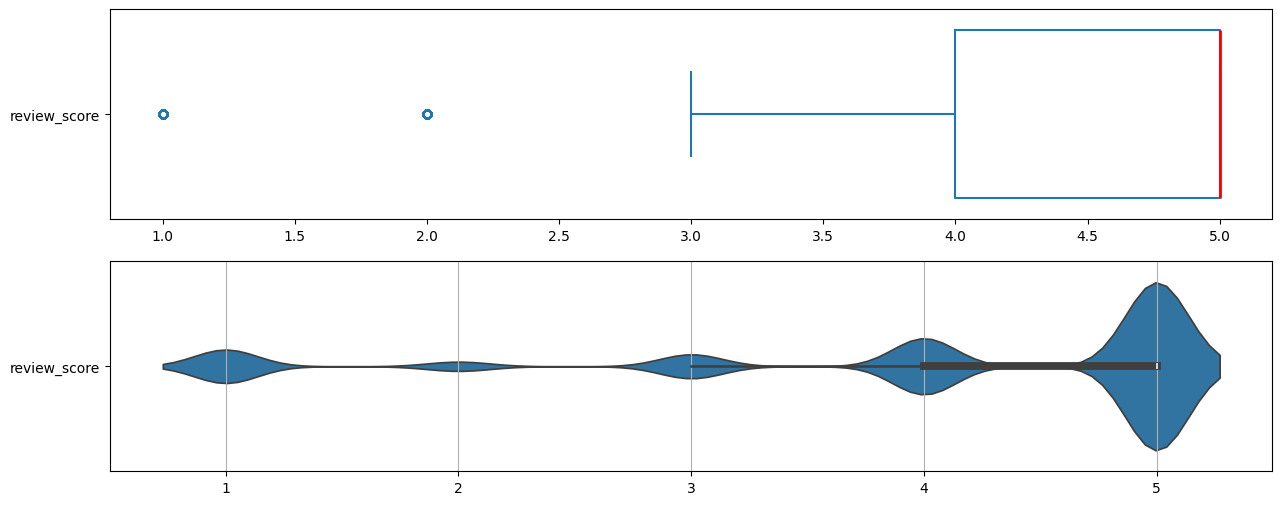

In [16]:
fig, ax = plt.subplots(nrows=2 ,ncols=1, figsize=(15,6) )
plt.grid(True)
sea.boxplot(score   , orient='h', ax=ax[0], medianprops={"color": "r", "linewidth": 2},fill=False)
sea.violinplot(score, orient='h', ax=ax[1])
plt.show()

> Os dados estão mais concentrados no '4-5' 
> Existe outliers , contudo não irei remove-los pois usei para resolver as perguntas abaixo...

Vou verificar se tem correlacao a nota do produto e se a pessoa comentou ou não

In [17]:
from scipy.stats import pointbiserialr
reviews = order_reviews.select(['review_score','review_comment_title'])\
    .withColumn(
    'Comentarios', f.when(f.col('review_comment_title').isNotNull(),1)\
        .otherwise(0) 
        ).toPandas()

reviews[['review_score','Comentarios']].corr()

,review_score,Comentarios
review_score,1.000000,-0.040565
Comentarios,-0.040565,1.000000


> Não tem uma correlacão entre a nota e se o pessoal comentou ou não

## Payments

In [18]:
VerificaValoresDuplicados(payments)

,Quantidade de valores duplicados,%
order_id,4446,4.2797
payment_sequential,103857,99.9721
payment_type,103881,99.9952
payment_installments,103862,99.9769
payment_value,74809,72.0107


In [19]:
VerificaValoresNulos('payments',payments)

Para o conjuto de dados Payments , com 103886 linhas


,Quantidade de valores Nulos,%
order_id,0,0.0
payment_sequential,0,0.0
payment_type,0,0.0
payment_installments,0,0.0
payment_value,0,0.0


In [20]:
payments.select(f.col('payment_value')).toPandas().describe()

,payment_value
count,103886.000000
mean,154.100380
std,217.494064
min,0.000000
25%,56.790000
50%,100.000000
75%,171.837500
max,13664.080000


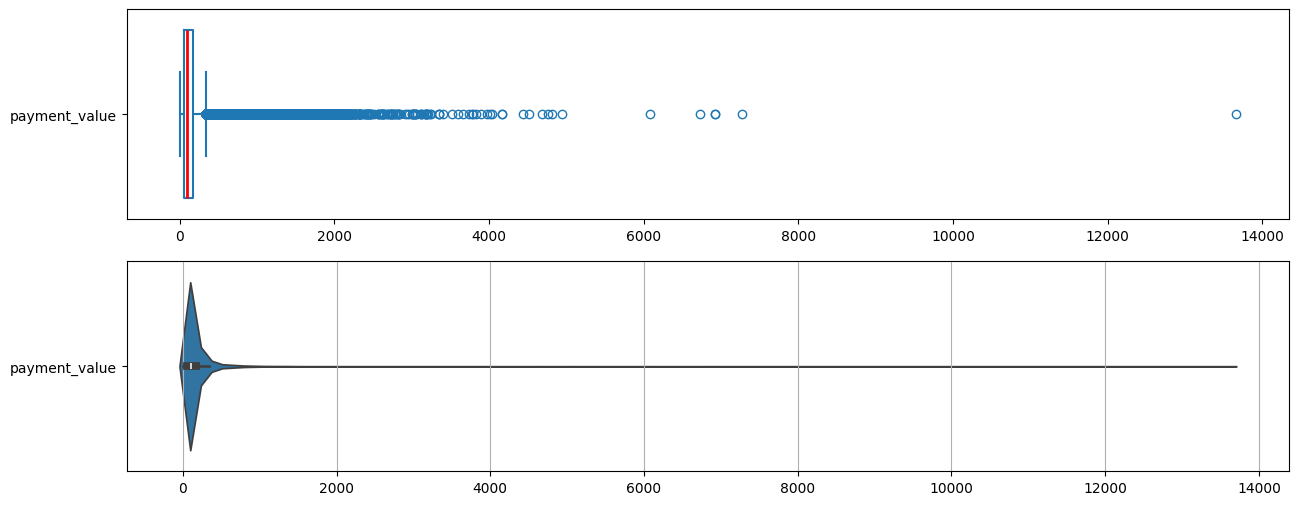

In [21]:
preços = payments.select(f.col('payment_value')).toPandas()

fig, ax = plt.subplots(nrows=2 ,ncols=1, figsize=(15,6))
plt.grid(True)
sea.boxplot(preços, orient='h', ax=ax[0], medianprops={"color": "r", "linewidth": 2},fill=False)
sea.violinplot(preços, orient='h', ax=ax[1])
plt.show()

In [22]:
quartil3 = np.percentile(preços,75)
quartil1 = np.percentile(preços,25)

#limite superior, limite inferior
ls = quartil3 + 1.5*(quartil3-quartil1) 
li = quartil1 - 1.5*(quartil3-quartil1)
ls, li

(344.40875000000005, -115.78125000000003)

> Tem outliers, maioria dos valores estão concentrado entre [0 - 344.40875000000005]

In [23]:
di = (preços.loc[(preços['payment_value'] > li ) & (preços['payment_value'] < ls) ])\
    .values.reshape(1,-1)[0]

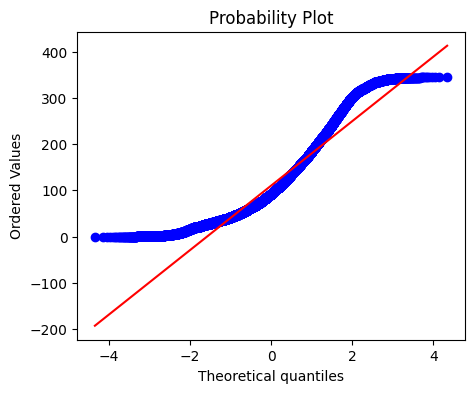

In [24]:
plt.figure(figsize=(5,4))
stats.probplot(x=di, plot=plt, dist='norm')
plt.show()

> Não seguem uma normal

In [25]:
newColumnOp = f.round(((f.col('Quantidade'))/payments.count())*100,3)

payments.select(f.col('payment_type').alias('Tipo de Pagamento'),
                f.col('payment_installments'))\
        .groupBy(f.col('Tipo de Pagamento'))\
            .agg(
                f.count(f.col('Tipo de Pagamento')).alias('Quantidade'),
                f.round( 
                        f.std( f.col('payment_installments') ),3
                    ).alias('Intervalo medio')
                )\
        .orderBy(f.col('Quantidade').desc())\
            .withColumn('%', newColumnOp).toPandas()

,Tipo de Pagamento,Quantidade,Intervalo medio,%
0,credit_card,76795,2.851,73.922
1,boleto,19784,0.000,19.044
2,voucher,5775,0.000,5.559
3,debit_card,1529,0.000,1.472
4,not_defined,3,0.000,0.003


> Maioria dos pagamentos efetuados foram no cartão de credito

In [21]:
parcelamento = payments.select(['payment_installments','payment_type'])\
                    .where(f.col('payment_type')=='credit_card').toPandas()['payment_installments']
parcelamento.describe()

count    76795.000000
mean         3.507155
std          2.850990
min          0.000000
25%          1.000000
50%          3.000000
75%          5.000000
max         24.000000
Name: payment_installments, dtype: float64

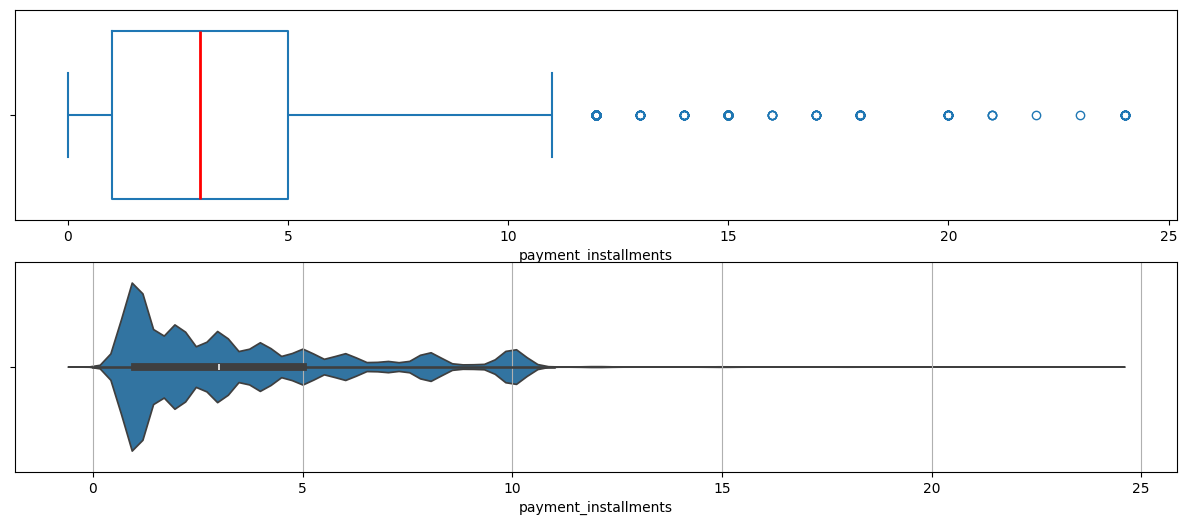

In [15]:
fig, ax = plt.subplots(nrows=2 ,ncols=1, figsize=(15,6))
plt.grid(True)
sea.boxplot(parcelamento, orient='h', ax=ax[0], medianprops={"color": "r", "linewidth": 2},fill=False)
sea.violinplot(parcelamento, orient='h', ax=ax[1])
plt.show()

> Tem outliers \
> Maior parte dos dados estão concentrados entre 1 e 5

&nbsp;

## Quais são categorias com maior e menor receita dos ultimos 12 meses?

In [ ]:
query = 'select min(order_purchase_timestamp) as tempoMin, max(order_purchase_timestamp) as tempoMax from orders;'
display( spark.sql(query).toPandas() )

,tempoMin,tempoMax
0,2016-09-04 21:15:19,2018-10-17 17:30:18


> O data vão de 2016 a 2019

Usando **Sql Spark** para fazer as questões \
Fazendo o `INNER JOIN` nas repestivas tabelas abaixo e com o `order_status!=cancelado` ,pois so será computado as vendas feitas(ou seja diferente de cancelado) assim consigo obter o valor real das Receitas de um produto, vender, estado.....
> Essa logica será feitas sobre as questões adiante que pedem `receitas` de algo

In [ ]:
query = '''
SELECT product_category_name , SUM(payment_value) as Receita FROM order_items as o_i
    INNER JOIN order_product as o_p ON
        o_p.product_id = o_i.product_id
    INNER JOIN orders as or ON
        or.order_id = o_i.order_id
    INNER JOIN payments as pay ON
        pay.order_id = or.order_id

    WHERE order_status != 'canceled' AND
        order_purchase_timestamp >= '2017-10-17 01:00:00' AND
        order_purchase_timestamp <= '2018-10-17 17:30:18' 
    GROUP BY product_category_name
    ORDER BY receita desc;
'''
data = spark.sql(query).toPandas()

In [ ]:
data.isna().nunique()

product_category_name    2
Receita                  1
dtype: int64

In [ ]:
data.loc[data['product_category_name'].isna()==True]

,product_category_name,Receita
21,None,150995.8


> Apesar de ter valores nulos isso não está afeta analise

Modificando a coluna `product_category_name` para torna-la mais legivel

In [ ]:
# Tirar o `_` e colacando o ' ' (espaco vazio) usando o replace
data['product_category_name'] = data['product_category_name'].str.replace('_',' ')
# Deixando as primeiras letras de cada palavra maiuscula
data['product_category_name'] = data['product_category_name'].str.title()

Usarei seaborn e matplotlib para visualização pois ele renderiza no github, diferente do plotly

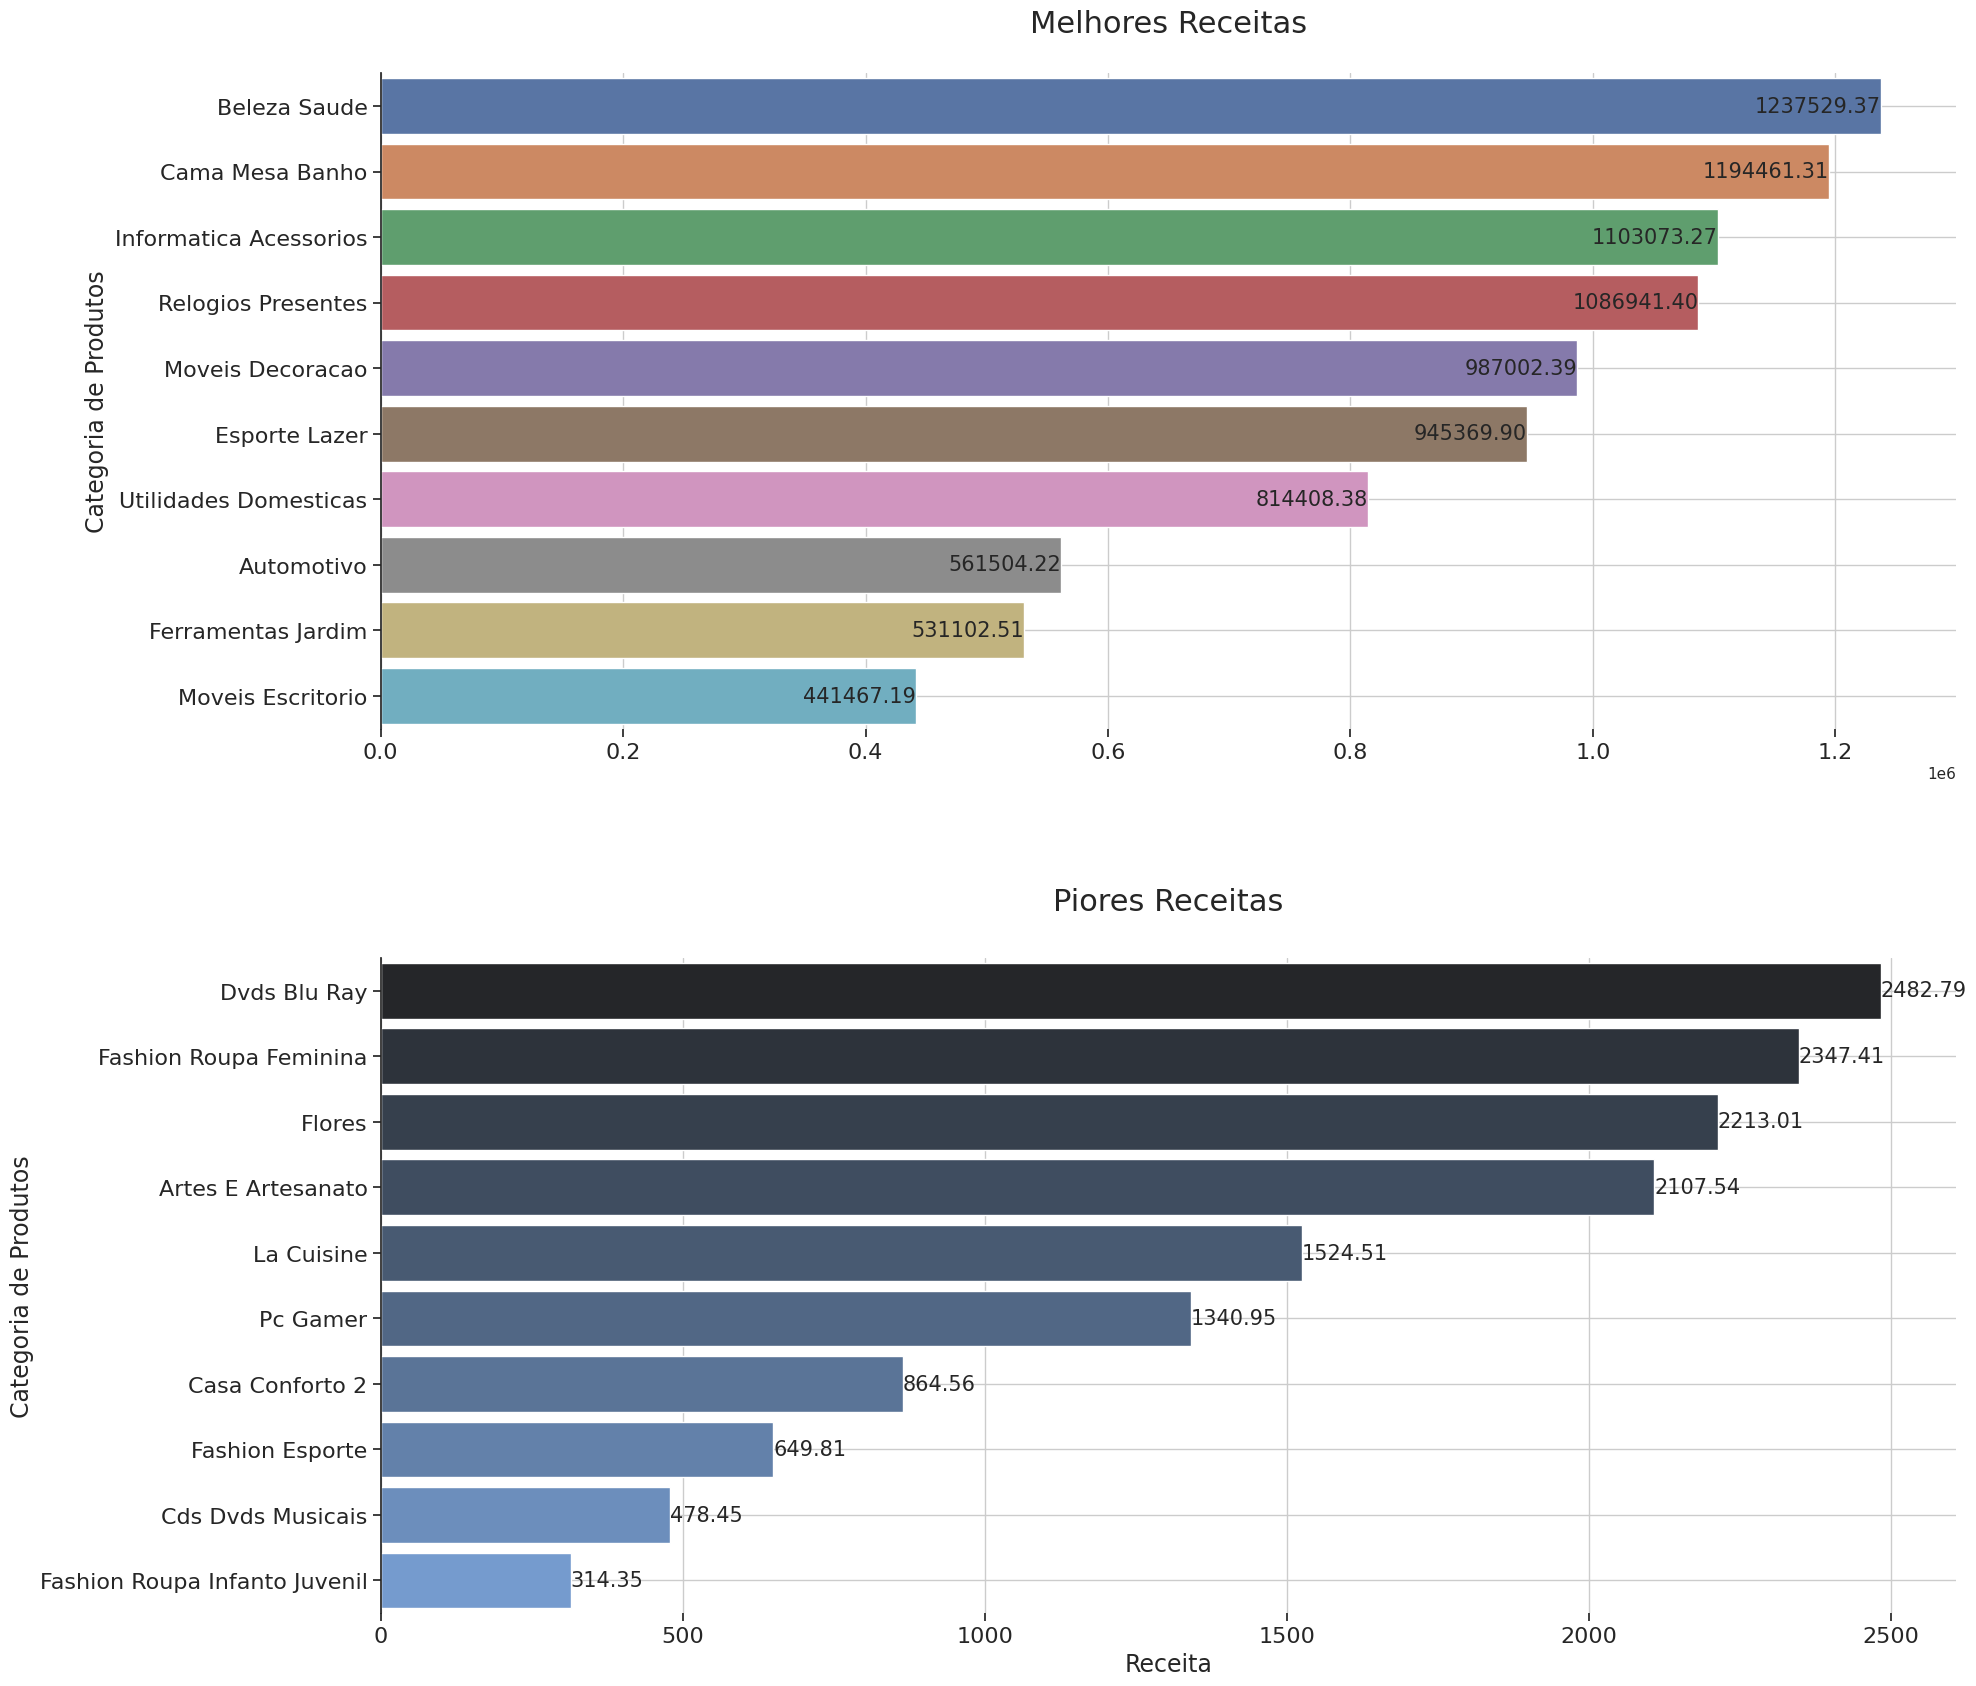

In [ ]:
sea.set_theme(context='notebook',style='ticks')  # Definindo estilo
fig, ax = plt.subplots(ncols=1,nrows=2,figsize=(18,20))
fig.subplots_adjust(hspace=0.35,right=1)        # Aumenta o espaço entre os graficos

# Grafico 1 = Melhores receitas
barMelhores = sea.barplot( data = data.iloc[0:10,:], 
    y='product_category_name', x='Receita', hue='product_category_name',width=0.85,
    palette= sea.color_palette('deep', 10) , ax = ax[0], legend=False
)

# Grafico 2 = Piores receitas
barPiores = sea.barplot(data=data.iloc[63:76,:], 
    y='product_category_name', x='Receita', hue='product_category_name',width=0.85,
    palette = sea.dark_palette("#69d",n_colors=10)  , ax = ax[1], legend=False
)

#Colocar text nas barras do graphico fiz dessa forma para
#economizar o numero de linhas
for graph,ha in zip([barMelhores,barPiores],['right','left']):
    for p in graph.patches:
        if p.get_width() != 0:
            xy = (p.get_width(), p.get_y()+p.get_height()/2)
            graph.annotate("%.2f" % p.get_width(),xy = xy, 
                xytext = (0, 0.1), textcoords= 'offset points', ha=ha, va = "center" ,size=15)

# Modificando Layout do grafico para deixar mais bonito
for axis in ax.flatten():
    axis.set_xlabel('')
    axis.set_ylabel('Categoria de Produtos',x=10,fontsize=17)
    axis.spines[['right','top','bottom']].set_visible(False)
    axis.tick_params('y', labelsize=16)
    axis.tick_params('x', labelsize=16)         
    axis.set_axisbelow(True)
    axis.grid(True)

#Modificando o Grafico 1
ax[0].set_title('Melhores Receitas',y=1.05,fontsize=22)

#Modificando o Grafico 2
ax[1].set_title('Piores Receitas',y=1.06,fontsize=22)       # Titulo 
ax[1].set_xlabel('Receita',fontsize=17)                     # Modificando eixo x
plt.show()

&nbsp;

## Top 10 maiores sellers (maior receita)?

In [ ]:
query = '''
SELECT (INITCAP(se.seller_city)|| '-' || se.seller_state) as seller ,
        ROUND(sum(payment_value),2) as receita FROM sellers AS se
    INNER JOIN order_items AS o_i ON
        o_i.seller_id = se.seller_id
    INNER JOIN payments AS py ON
        py.order_id  = o_i.order_id
    INNER JOIN orders AS o_r ON
        o_r.order_id = py.order_id
    WHERE order_status != 'canceled'  
    GROUP BY seller
    ORDER BY receita desc limit 10; 
'''
data = spark.sql(query).toPandas()

In [ ]:
data.isna().nunique()

seller     1
receita    1
dtype: int64

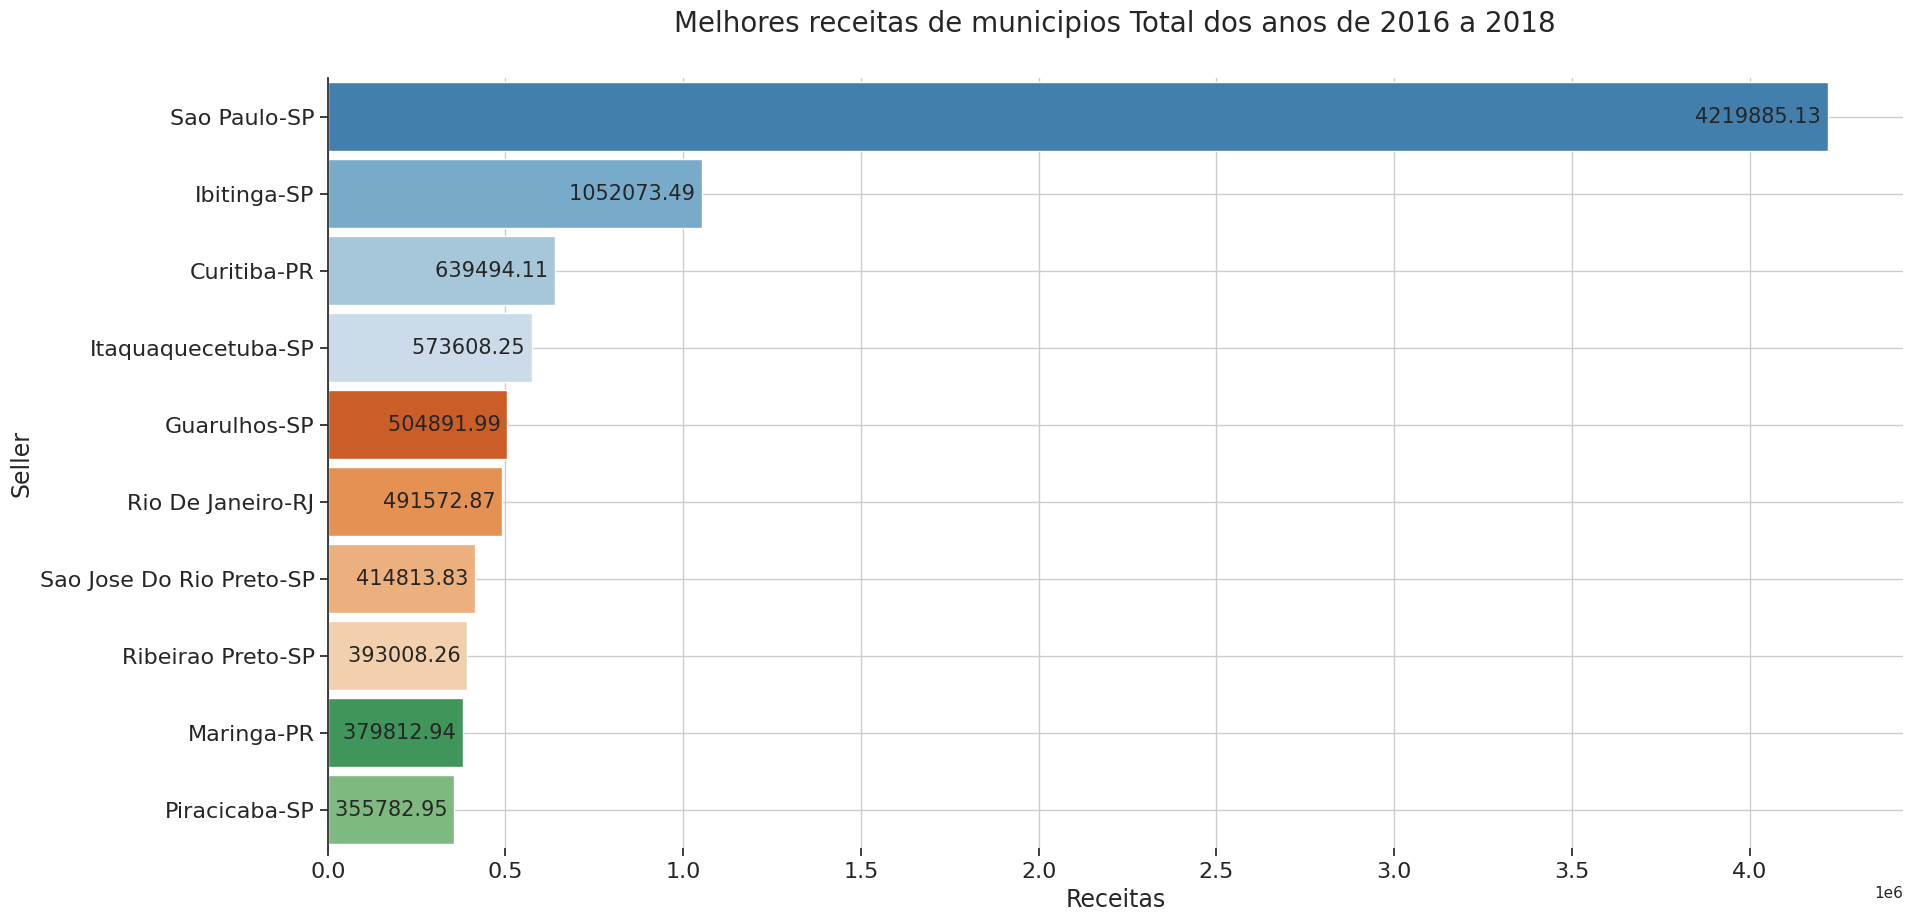

In [ ]:
sea.set_theme(style="ticks")                # Definindo estilo
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(18,10))
fig.subplots_adjust(hspace=0.25,right=1)    # Aumenta o espaço entre os graficos

# Grafico 1 = Melhores receitas
barMelhores = sea.barplot( data = data.iloc[0:10,:], palette=sea.color_palette('tab20c',n_colors=10),
    y='seller', x='receita', hue='seller', width=0.9, ax = ax, legend=False)

#Modificando o Grafico 1
ax.set_title('Melhores receitas de municipios Total dos anos de 2016 a 2018',y=1.05,fontsize=20)
ax.set_ylabel('Seller',x=10,fontsize=17)
ax.set_xlabel('Receitas',fontsize=17)
ax.spines[['right','top','bottom']].set_visible(False)
ax.tick_params('y', labelsize=16)
ax.tick_params('x', labelsize=16)         
ax.set_axisbelow(True)
ax.grid(True)

# Colocando o valor das receitas nas barras
for p in barMelhores.patches:
    if p.get_width() != 0:
        barMelhores.annotate(("%.2f" % p.get_width())+' ',  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.1), textcoords= 'offset points', ha = 'right', va = "center" ,size=15)

In [ ]:
query = '''
SELECT seller_state, order_approved_at, payment_value FROM sellers AS se 
    INNER JOIN order_items AS o_i ON
        o_i.seller_id = se.seller_id
    INNER JOIN payments AS py ON
        py.order_id  = o_i.order_id
    INNER JOIN orders AS o_r ON
        o_r.order_id = py.order_id;
'''
dataSql = spark.sql(query).na.drop()

Vou usar o spark para fazer essa operação, depois passarei para pandas para visualização

In [ ]:
dataSpark = dataSql.groupby(
    [f.col('seller_state') ,f.year( f.col('order_approved_at') ).alias('ano')] )\
    .agg( 
        f.round(f.sum(f.col('payment_value'))).alias('receita') )\
    .orderBy( 
        f.col('receita').desc() )
dataPd = dataSpark.toPandas()

Plotando usando um loop

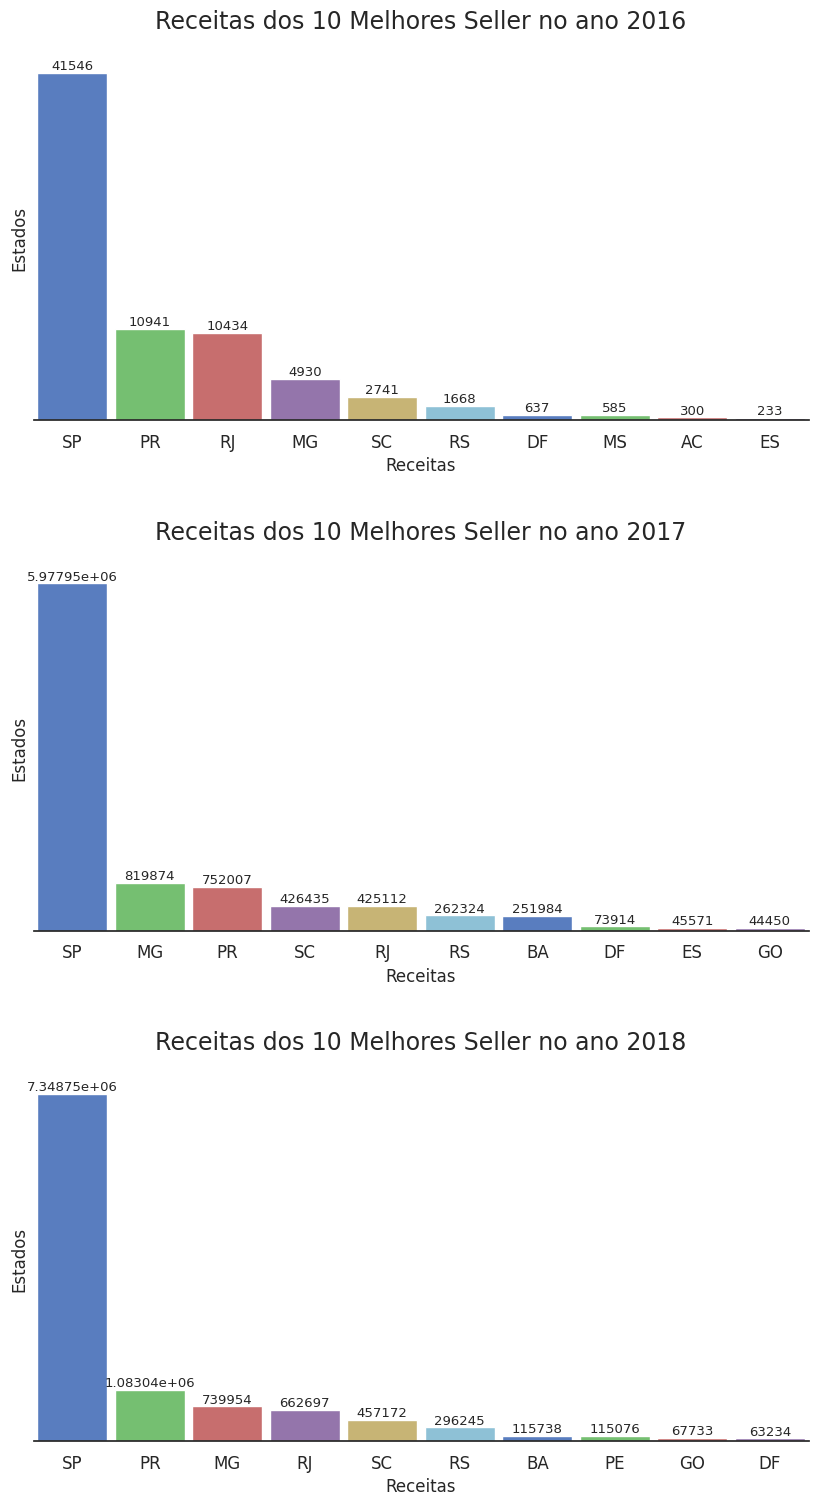

In [ ]:
sea.set_theme('notebook',style='white',palette=None)
fig, ax = plt.subplots(ncols=1,nrows=3, figsize=(10,18))
fig.subplots_adjust(hspace=0.4)

for ano, axi, color in zip(range(2016, 2019),ax.flatten(),['muted6','muted6','muted6']):
    selecti = dataPd.loc[ dataPd['ano'] == ano ].iloc[0:10,:]
    bar = sea.barplot(
        data=selecti, y='receita', x='seller_state', hue='seller_state', ax=axi,
        palette=sea.color_palette(color,n_colors=10) , width=1, gap=0.1
    )
    axi.set_title(f'Receitas dos 10 Melhores Seller no ano {ano}', fontsize=17,y=1.05)
    axi.set_ylabel('Estados', fontsize=12)
    axi.set_xlabel('')
    axi.tick_params('x', labelsize=12)
    axi.set_yticks([])
    axi.spines[['right','top','left']].set_visible(False)
    axi.set_xlabel('Receitas', fontsize=12)


    for i in bar.containers: bar.bar_label(i,fontsize=9.5)

plt.show()

&nbsp;

## Top 10 piores sellers?

In [ ]:
query = '''
SELECT o_i.seller_id, sum(payment_value) as receita FROM sellers AS se 
    INNER JOIN order_items AS o_i ON
        o_i.seller_id = se.seller_id
    INNER JOIN payments AS py ON
        py.order_id  = o_i.order_id
    INNER JOIN orders AS o_r ON
        o_r.order_id = py.order_id
    GROUP BY o_i.seller_id ;
'''

spark.sql(query).show()

+--------------------+------------------+
|           seller_id|           receita|
+--------------------+------------------+
|ff063b022a9a0aab9...|          14862.57|
|8e6cc767478edae94...|          10154.07|
|a49928bcdf77c55c6...|12521.220000000001|
|da7039f29f90ce5b4...|           1873.76|
|062ce95fa2ad4dfae...|          10730.16|
|2009a095de2a2a416...|           1275.73|
|0ea22c1cfbdc755f8...|20780.680000000004|
|6eeed17989b0ae47c...|            819.53|
|e63e8bfa530fb1691...|           2311.44|
|4d600e08ecbe08258...|           4633.46|
|9803a40e82e45418a...|21265.199999999997|
|b3f19518fcec265b2...|            624.48|
|ec8879960bd2221d5...| 4881.380000000001|
|0b64bcdb0784abc13...|            205.81|
|c522be04e020c1e7b...|             838.3|
|9c068d10aca38e85c...|3771.6000000000004|
|297d5eccd19fa9a83...|            976.73|
|9b1050e85becf3ae9...|            115.34|
|e38db885400cd35c7...|           3060.49|
|13fa2a6c6b9d0f43c...| 5666.280000000001|
+--------------------+------------

&nbsp;

## Existem sellers que vendem o mesmo produto? se sim quais são? Qual a variação de preço praticada entre os sellers?

Usarei o pandas para fazer o group by pois fica melhor de visualizar a tabela ou ela organiza melhor quando usa duas colunas para essa operação

In [ ]:
query = '''
SELECT seller_state, product_category_name,price FROM sellers AS se
    INNER JOIN order_items AS o_i ON
        se.seller_id = o_i.seller_id
    INNER JOIN order_product AS op ON
        op.product_id = o_i.product_id
'''
data = spark.sql(query).na.drop().toPandas()

In [ ]:
resultado = data.groupby(by=['seller_state', 'product_category_name'])['price'].mean().reset_index()
resultado.dropna(inplace=True)
resultado.head(3)

,seller_state,product_category_name,price
0,AC,livros_tecnicos,267.000000
1,AM,telefonia,392.333333
2,BA,alimentos_bebidas,124.535405


In [ ]:
def VarianciaDeLojas(data:pd.DataFrame):
    dicionario = {'States':[],'Produto':[],'Variação':[]}
    for enum ,statei in data.iterrows():
        for _ ,statej in data.iloc[enum:,:].iterrows():
            if (statei['seller_state'] != statej['seller_state']):
                if (statei['product_category_name'] == statej['product_category_name']):
                    dicionario['Produto'].append(statei['product_category_name'])
                    dicionario['States'].append(statei['seller_state'] +'-'+statej['seller_state'])
                    variacao =  ((statei['price'] - statej['price']))
                    dicionario['Variação'].append(variacao)
    return pd.DataFrame(dicionario)

In [ ]:
VarianciaDeLojas(resultado)

,States,Produto,Variação
0,AC-CE,livros_tecnicos,217.000000
1,AC-PR,livros_tecnicos,207.028462
2,AC-RJ,livros_tecnicos,224.100000
3,AC-RS,livros_tecnicos,137.666667
4,AC-SP,livros_tecnicos,195.989715
...,...,...,...
1966,SC-SP,telefonia,75.216822
1967,SC-SP,utilidades_domesticas,108.961782
1968,SE-SP,cama_mesa_banho,9.267790
1969,SE-SP,industria_comercio_e_negocios,241.355784


&nbsp;

### Ouve inflação de preço dos produtos ?

### Top 10 seller com review positivas

In [ ]:
order_reviews.show()

+--------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+
|           review_id|            order_id|review_score|review_comment_title|review_comment_message|review_creation_date|review_answer_timestamp|
+--------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+
|7bc2406110b926393...|73fc7af87114b3971...|           4|                NULL|                  NULL| 2018-01-18 00:00:00|    2018-01-18 21:46:59|
|80e641a11e56f04c1...|a548910a1c6147796...|           5|                NULL|                  NULL| 2018-03-10 00:00:00|    2018-03-11 03:05:13|
|228ce5500dc1d8e02...|f9e4b658b201a9f2e...|           5|                NULL|                  NULL| 2018-02-17 00:00:00|    2018-02-18 14:36:24|
|e64fb393e7b32834b...|658677c97b385a9be...|           5|                NULL|  Recebi bem antes ...| 2017-04-21 00:00:00|   

In [ ]:
orderRev = order_reviews.na.drop(subset=['review_id','order_id','review_score'])

In [ ]:
df = orderRev.select(f.col('review_score')).toPandas()
df['review_score'].value_counts()

review_score
5                      57328
4                      19142
1                      11424
3                       8179
2                       3151
                       ...  
2018-04-05 11:09:51        1
2018-01-24 16:04:49        1
2017-08-17 10:49:44        1
2018-06-17 21:30:05        1
2017-08-21 15:27:32        1
Name: count, Length: 2442, dtype: int64

In [ ]:
import plotly.graph_objects as go

# Dados de exemplo (substitua pelos seus dados)
categorias = ['Categoria 1', 'Categoria 2', 'Categoria 3']
valores = [20, 30, 50]  # Valores para cada categoria

# Criar o treemap
fig = go.Figure(go.Treemap(
    labels=categorias,
    parents=['', '', ''],
    values=valores
))

# Atualizar o layout
fig.update_layout(
    title='Gráfico Icicle',
    margin=dict(t=50, l=25, r=25, b=25)  # Margem para evitar cortar o título
)

fig.write_image('img.png')